In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import PoissonRegressor

%cd C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj\

C:\Users\user\Desktop\KUL - Mstat\Modern Data Analytics\proj


In [2]:
# import data
mortality = pd.read_csv('mortality_merged.csv')

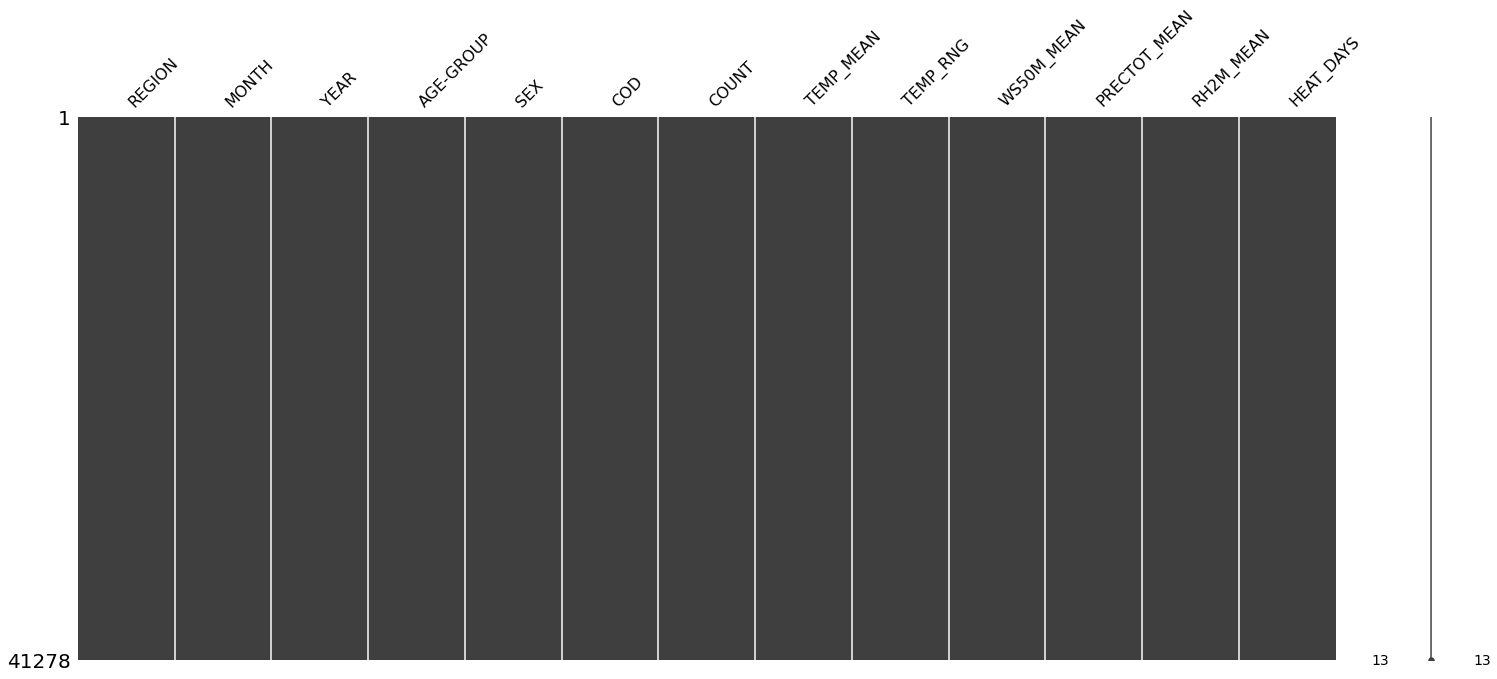

In [3]:
# Check for missing values, it seems alright
missingno.matrix(mortality)

In [4]:
class subset_helper():
    def __init__(self, data):
        self.data = data
        
    def get_summer(self, df):
        return df[(df['MONTH'] <= 8) & (df['MONTH'] >= 5)]

    def get_disease(self, df):
        diseases = ('Diseases of the circulatory system', 
                    'Diseases of the respiratory system', 
                    'Diseases of the skin and subcutaneous tissue')
        return df[df['COD'].isin(diseases)]
    
    def subset(self):
        self.data = self.get_summer(self.data)
        self.data = self.get_disease(self.data)
        return self.data
mortality = subset_helper(mortality).subset()

In [5]:
# Train-test split
TEST_SIZE = 0.2
SEED = 467051528
X_train, X_test, y_train, y_test = train_test_split(mortality.drop('COUNT', axis = 1), 
                                                    mortality['COUNT'], 
                                                    test_size = TEST_SIZE,
                                                    random_state = SEED,
                                                    shuffle = True)

In [6]:
# Preprocessing steps
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(drop = 'first')

categorical_features = ['REGION', 'AGE-GROUP', 'SEX', 'COD']
numeric_features = X_train.columns.to_list()[6:]

preprocessor = ColumnTransformer(
    transformers = [
        ('drop_columns', 'drop', ['YEAR', 'MONTH']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [7]:
# Parameter grids
n = np.arange(1, 16)
alpha = np.arange(0, 2, 0.05)
params = {'preprocessing__num' : [StandardScaler(), RobustScaler()], 
         'dimension_reduction__n_components': n,
         'regressor__alpha': alpha}

In [8]:
# Model
model = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('dimension_reduction', TruncatedSVD()),
    ('regressor', PoissonRegressor())
])

In [9]:
# Grid search
search = RandomizedSearchCV(model, 
                            param_distributions = params, 
                            random_state = SEED)
search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('drop_columns',
                                                                               'drop',
                                                                               ['YEAR',
                                                                                'MONTH']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TEMP_MEAN',
                                                                                'TEMP_RNG',
                                                                                'W

In [10]:
# Summary of grid search
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__alpha,param_preprocessing__num,param_dimension_reduction__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015506,0.000242,0.002001,4.002476e-03,0.05,StandardScaler(),8,"{'regressor__alpha': 0.05, 'preprocessing__num...",0.134693,0.064828,0.107603,0.164353,0.129571,0.120210,0.033082,6
1,0.008449,0.007254,0.008665,6.606156e-03,1.1,RobustScaler(),6,"{'regressor__alpha': 1.1, 'preprocessing__num'...",0.080018,0.022763,0.109227,0.140251,0.083319,0.087116,0.038777,8
2,0.011788,0.000999,0.002854,3.540132e-03,0.3,StandardScaler(),10,"{'regressor__alpha': 0.30000000000000004, 'pre...",0.187865,0.149516,0.144494,0.197089,0.136614,0.163116,0.024498,5
3,0.012485,0.003886,0.008040,4.019986e-03,1.55,RobustScaler(),15,"{'regressor__alpha': 1.55, 'preprocessing__num...",0.723223,0.735345,0.727603,0.743272,0.713081,0.728505,0.010310,1
4,0.011755,0.002528,0.008496,1.573457e-03,0.5,StandardScaler(),5,"{'regressor__alpha': 0.5, 'preprocessing__num'...",0.080836,0.028908,0.047305,0.059518,0.067555,0.056824,0.017714,9
5,0.014403,0.001497,0.005201,4.002573e-04,1.3,RobustScaler(),10,"{'regressor__alpha': 1.3, 'preprocessing__num'...",0.190167,0.159098,0.161568,0.199556,0.154862,0.173050,0.018182,4
6,0.014203,0.000400,0.005001,2.780415e-07,0.3,StandardScaler(),14,"{'regressor__alpha': 0.30000000000000004, 'pre...",0.608162,0.556612,0.491232,0.559638,0.528011,0.548731,0.038597,3
7,0.012203,0.001470,0.004801,4.003050e-04,0.3,RobustScaler(),6,"{'regressor__alpha': 0.30000000000000004, 'pre...",0.083142,0.020230,0.109890,0.142792,0.082910,0.087793,0.040307,7
8,0.011003,0.001095,0.005202,7.455915e-04,1.2,StandardScaler(),1,"{'regressor__alpha': 1.2000000000000002, 'prep...",-0.003395,-0.004568,-0.004287,-0.001096,-0.003265,-0.003322,0.001220,10
9,0.017403,0.001199,0.005402,4.893375e-04,1.6,StandardScaler(),15,"{'regressor__alpha': 1.6, 'preprocessing__num'...",0.712391,0.727766,0.718729,0.735367,0.703766,0.719604,0.011124,2


In [11]:
# Best fitted scores
print(search.best_params_)
print('Best scores: ', search.best_score_)

{'regressor__alpha': 1.55, 'preprocessing__num': RobustScaler(), 'dimension_reduction__n_components': 15}
Best scores:  0.7285049635013395


In [12]:
# Test performance
model_chosen = search.best_estimator_
y_pred = model_chosen.predict(X_test)

In [13]:
# Test loss
mean_squared_error(y_pred, y_test)

1883.989575573811

In [14]:
# Training loss
mean_squared_error(y_train, model_chosen.predict(X_train))

1802.8487029366734

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


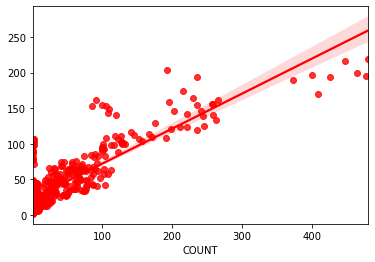

In [15]:
# Test data: y_test, y_pred
sns.regplot(y_test, y_pred, color = 'red')

In [16]:
# R-squared between y_pred and y_test
np.corrcoef(y_test, y_pred)

array([[1.        , 0.85586323],
       [0.85586323, 1.        ]])

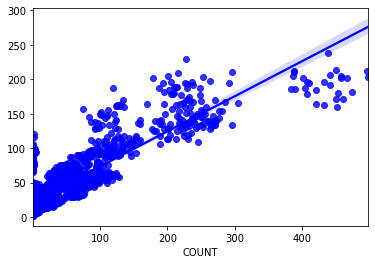

In [17]:
# Training data: y_test, y_pred_train
y_pred_train = model_chosen.predict(X_train)
sns.regplot(x = y_train, y = y_pred_train, color = 'blue')

In [18]:
# R-squared between y_pred and y_pred_train
np.corrcoef(y_train, y_pred_train)

array([[1.        , 0.86980847],
       [0.86980847, 1.        ]])